In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
import torch
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import Image

## Simulation Parameters

In [2]:
dt = torch.Tensor([0.04])  # timestep
t = torch.Tensor([1])  # duration
m = torch.Tensor([1])  # mass
q0 = torch.Tensor([0, 0, 1])  # init pos
v0 = torch.Tensor([1, 2, 2])  # init vel
v0.requires_grad = True
g = torch.Tensor([9.8])  # gravitational acceleration
n = torch.Tensor([0, 0, 1])  # phi(q) = n @ q

## Simulation Backend

In [3]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]

In [4]:
class Block2DImpact(SimSystem):
    def __init__(self, pos, vel, mass,
                 dt=0.1, solver='ECOS'):
        super().__init__(pos, vel)
        self.m = mass
        self.dt = dt
        self.solver = solver
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, return_dual=False, update=True):
        e_z = np.array([[0., 0., 1.]], dtype=np.float32)
        with torch.no_grad():
            v = cp.Variable(self.dim)
            constraints = [self.dt * (n @ v) >= -n @ self.q]
            prob = cp.Problem(cp.Minimize(0.5 * self.m * cp.norm(v, 2)**2 - self.m * v @ self.v + self.dt * g * self.m * n @ v), constraints)
            prob.solve(solver=self.solver)
            v_new = v.value
            lamb = constraints[0].dual_value
            v_lamb = torch.Tensor(np.hstack((v_new, lamb)))
            J = torch.from_numpy(np.block([
                [lamb * self.dt.numpy() * e_z, e_z @ (self.dt.numpy() * v_new + self.q.numpy())],
                [self.m.numpy() * np.eye(len(v_new)), e_z.T]
            ]))
        e_z_t = torch.from_numpy(e_z)
        vlc = v_lamb.clone()
        subtract_val = torch.cat((vlc[-1] * e_z_t @ (self.dt * vlc[:-1] + self.q),
                                     self.m * (vlc[:-1] - self.v) + e_z_t[0] * vlc[-1] + self.dt * g * self.m * n))
        # if not torch.allclose(subtract_val, torch.zeros_like(subtract_val), atol=1e-2):
        #     breakpoint()
        v_lamb -= subtract_val
        v_lamb.register_hook(lambda grad: torch.solve(grad[:,None], J.T.float())[0][:,0])
        if update:
            self.v = v_lamb[:-1]
        return v_lamb[:-1] if not return_dual else v_lamb[:-1], v_lamb
    
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [5]:
def sim(system, timesteps=10, return_dual=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs, vs = [system.q.detach().numpy()], [system.v.detach().numpy()]
    t = 0
    if return_dual:
        duals = []
    while t < timesteps:
        q = system.step_q()
        if return_dual:
            v, lamb = system.step_v(return_dual=return_dual)
            duals.append(lamb)
        else:
            v = system.step_v(return_dual=return_dual)
        qs.append(q.detach().numpy())
        vs.append(v.detach().numpy())
        t += system.dt
    return np.stack(qs) if not return_dual else np.stack(qs), np.array(duals)

In [6]:
system = Block2DImpact(q0, v0, m, dt, solver='ECOS')
qs, duals = sim(system, timesteps=t, return_dual=True)

In [7]:
qs, duals

(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 3.99999991e-02,  7.99999982e-02,  1.08000004e+00],
        [ 8.00015777e-02,  1.60001576e-01,  1.14431214e+00],
        [ 1.20003626e-01,  2.40003631e-01,  1.19294453e+00],
        [ 1.60005957e-01,  3.20005983e-01,  1.22589600e+00],
        [ 2.00008452e-01,  4.00008470e-01,  1.24316764e+00],
        [ 2.40010202e-01,  4.80010241e-01,  1.24476087e+00],
        [ 2.80011982e-01,  5.60011983e-01,  1.23067427e+00],
        [ 3.20014060e-01,  6.40014052e-01,  1.20090699e+00],
        [ 3.60016644e-01,  7.20016658e-01,  1.15545869e+00],
        [ 4.00019199e-01,  8.00019205e-01,  1.09432995e+00],
        [ 4.40022111e-01,  8.80022109e-01,  1.01752019e+00],
        [ 4.80025023e-01,  9.60025012e-01,  9.25030410e-01],
        [ 5.20027936e-01,  1.04002786e+00,  8.16860557e-01],
        [ 5.60030818e-01,  1.12003076e+00,  6.93010688e-01],
        [ 6.00033760e-01,  1.20003366e+00,  5.53480983e-01],
        [ 6.40036941e-01

## Plot

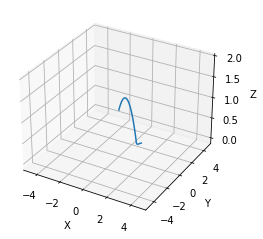

In [8]:
Writer = animation.writers['pillow']
writer = Writer(fps=int(1/dt), bitrate=600)

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

fig = plt.figure()
ax = fig.gca(projection='3d')
line, = ax.plot(qs[:1, 0], qs[:1, 1], qs[:1, 2])
ax.set_xlim3d([-5, 5])
ax.set_xlabel('X')
ax.set_ylim3d([-5, 5])
ax.set_ylabel('Y')
ax.set_zlim3d([-0.1, 2])
ax.set_zlabel('Z')
ani = animation.FuncAnimation(fig, update, int(t / dt), fargs=(qs.T, line), interval=dt, blit=False)
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/impact/sim2d_impact_{time}.gif'
ani.save(filename, writer=writer)

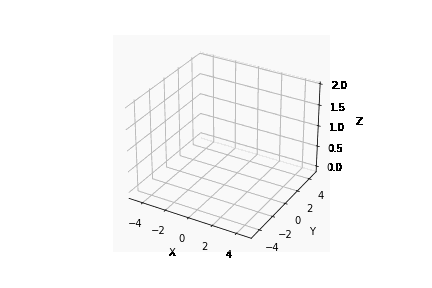

In [9]:
Image(filename=filename)